# Forecasting  an AR(1) process

In [1]:
!pip install arviz pymc

This lecture describes methods for forecasting statistics that are functions of future values of a univariate autogressive process.  

The methods are designed to take into account two possible sources of uncertainty about these statistics:

- random shocks that impinge of the transition law

- uncertainty about the parameter values of the AR(1) process

We consider two sorts of statistics:

- prospective values $y_{t+j}$ of a random process $\{y_t\}$ that is governed by the AR(1) process

- sample path properties that are defined as non-linear functions of future values $\{y_{t+j}\}_{j \geq 1}$ at time $t$

**Sample path properties** are things like "time to next turning point" or "time to next recession".

To investigate sample path properties we'll use a simulation procedure recommended by Wecker {cite}`wecker1979predicting`.

To acknowledge uncertainty about parameters, we'll deploy `pymc` to construct a Bayesian joint posterior distribution for unknown parameters.

Let's start with some imports.

In [2]:
import numpy as np
import arviz as az
import pymc as pmc
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
colors = sns.color_palette()

import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)

## A Univariate First-Order Autoregressive Process

Consider the univariate AR(1) model: 

$$ 
y_{t+1} = \rho y_t + \sigma \epsilon_{t+1}, \quad t \geq 0 
$$ (ar1-tp-eq1) 

where the scalars $\rho$ and $\sigma$ satisfy $|\rho| < 1$ and $\sigma > 0$; 
$\{\epsilon_{t+1}\}$ is a sequence of i.i.d. normal random variables with mean $0$ and variance $1$. 

The initial condition $y_{0}$ is a known number. 

Equation {eq}`ar1-tp-eq1` implies that for $t \geq 0$, the conditional density of $y_{t+1}$ is

$$
f(y_{t+1} | y_{t}; \rho, \sigma) \sim {\mathcal N}(\rho y_{t}, \sigma^2) \
$$ (ar1-tp-eq2)

Further, equation {eq}`ar1-tp-eq1` also implies that for $t \geq 0$, the conditional density of $y_{t+j}$ for $j \geq 1$ is

$$
f(y_{t+j} | y_{t}; \rho, \sigma) \sim {\mathcal N}\left(\rho^j y_{t}, \sigma^2 \frac{1 - \rho^{2j}}{1 - \rho^2} \right) 
$$ (ar1-tp-eq3)

The predictive distribution {eq}`ar1-tp-eq3` that assumes that the parameters $\rho, \sigma$ are known, which we express
by conditioning on them.

We also want to compute a  predictive distribution that does not condition on $\rho,\sigma$ but instead takes account of our uncertainty about them.

We form this predictive distribution by integrating {eq}`ar1-tp-eq3` with respect to a joint posterior distribution $\pi_t(\rho,\sigma | y^t)$ 
that conditions on an observed history $y^t = \{y_s\}_{s=0}^t$:

$$ 
f(y_{t+j} | y^t)  = \int f(y_{t+j} | y_{t}; \rho, \sigma) \pi_t(\rho,\sigma | y^t ) d \rho d \sigma
$$ (ar1-tp-eq4)

Predictive distribution {eq}`ar1-tp-eq3` assumes that parameters $(\rho,\sigma)$ are known.

Predictive distribution {eq}`ar1-tp-eq4` assumes that parameters $(\rho,\sigma)$ are uncertain, but have known probability distribution $\pi_t(\rho,\sigma | y^t )$.

We also want to compute some  predictive distributions of "sample path statistics" that might  include, for example

- the time until the next "recession",
- the minimum value of $Y$ over the next 8 periods,
- "severe recession", and
- the time until the next turning point (positive or negative).

To accomplish that for situations in which we are uncertain about parameter values, we shall extend Wecker's {cite}`wecker1979predicting` approach in the following way.

- first simulate an initial path of length $T_0$;
- for a given prior, draw a sample of size $N$ from the posterior joint distribution of parameters $\left(\rho,\sigma\right)$ after observing the initial path;
- for each draw $n=0,1,...,N$, simulate a "future path" of length $T_1$ with parameters $\left(\rho_n,\sigma_n\right)$ and compute our three "sample path statistics";
- finally, plot the desired statistics from the $N$ samples as an empirical distribution.

## Implementation

First, we'll simulate a  sample path from which to launch our forecasts.  

In addition to plotting the sample path, under the assumption that the true parameter values are known,
we'll plot $.9$ and $.95$ coverage intervals using conditional distribution
{eq}`ar1-tp-eq3` described above. 

We'll also plot a bunch of samples of sequences of future values and watch where they fall relative to the coverage interval.

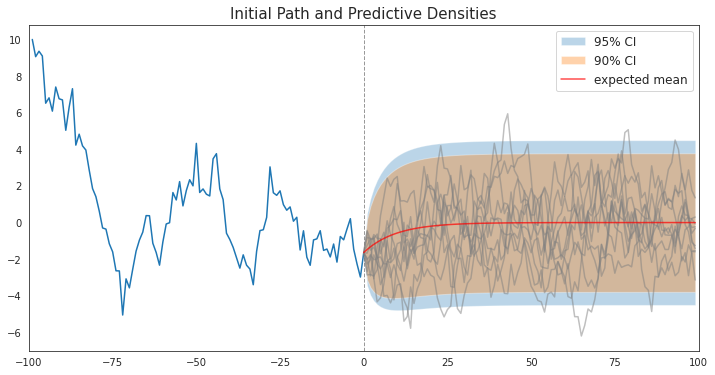

In [3]:
def AR1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0, sigma, T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho * y[t-1] + eps[t]
        
    return y


def plot_initial_path(initial_path):
    """
    Plot the initial path and the preceding predictive densities
    """
    # Compute .9 confidence interval]
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title("Initial Path and Predictive Densities", fontsize=15)
    ax.plot(np.arange(-T0 + 1, 1), initial_path)
    ax.set_xlim([-T0, T1])
    ax.axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Simulate future paths
    for i in range(10):
        y_future = AR1_simulate(rho, sigma, y0, T1)
        ax.plot(np.arange(T1), y_future, color='grey', alpha=.5)
    
    # Plot 90% CI
    ax.fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3, label='95% CI')
    ax.fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35, label='90% CI')
    ax.plot(np.arange(T1), center, color='red', alpha=.7, label='expected mean')
    ax.legend(fontsize=12)
    plt.show()


sigma =  1
rho = 0.9
T0, T1 = 100, 100
y0 = 10

# Simulate
np.random.seed(145)
initial_path = AR1_simulate(rho, sigma, y0, T0)

# Plot
plot_initial_path(initial_path)

As functions of forecast horizon, the coverage intervals have shapes like those described in 
https://python.quantecon.org/perm_income_cons.html


## Predictive Distributions of Path Properties

Wecker {cite}`wecker1979predicting` proposed using simulation techniques to characterize  predictive distribution of some statistics that are  non-linear functions of $y$. 

He called these functions "path properties" to contrast them with properties of single data points.

He studied two special  prospective path properties of a given series $\{y_t\}$. 

The first was **time until the next turning point**.

* he defined a **"turning point"** to be the date of the  second of two successive declines in  $y$. 

To examine this statistic, let $Z$ be an indicator process

<!-- $$
Z_t(Y(\omega)) := \left\{ 
\begin{array} {c}
\ 1 & \text{if } Y_t(\omega)< Y_{t-1}(\omega)< Y_{t-2}(\omega) \geq Y_{t-3}(\omega) \\
0 & \text{otherwise}
\end{array} \right.
$$ -->



$$
Z_t(Y(\omega)) :=  
\begin{cases} 
\ 1 & \text{if } Y_t(\omega)< Y_{t-1}(\omega)< Y_{t-2}(\omega) \geq Y_{t-3}(\omega) \\
0 & \text{otherwise}
\end{cases} 
$$

Then the random variable **time until the next turning point**  is defined as the following **stopping time** with respect to $Z$:

$$
W_t(\omega):= \inf \{ k\geq 1 \mid Z_{t+k}(\omega) = 1\}
$$

Wecker  {cite}`wecker1979predicting` also studied **the minimum value of $Y$ over the next 8 quarters**
which can be defined as the random variable.

$$ 
M_t(\omega) := \min \{ Y_{t+1}(\omega); Y_{t+2}(\omega); \dots; Y_{t+8}(\omega)\}
$$

It is interesting to study yet another possible concept of a **turning point**.

Thus, let
<!-- 
$$
T_t(Y(\omega)) := \left\{ 
\begin{array}{c}
\ 1 & \text{if } Y_{t-2}(\omega)> Y_{t-1}(\omega) > Y_{t}(\omega) \ \text{and } \ Y_{t}(\omega) < Y_{t+1}(\omega) < Y_{t+2}(\omega) \\
\ -1 & \text{if } Y_{t-2}(\omega)< Y_{t-1}(\omega) < Y_{t}(\omega) \ \text{and } \ Y_{t}(\omega) > Y_{t+1}(\omega) > Y_{t+2}(\omega) \\
0 & \text{otherwise}
\end{array} \right.
$$ -->


$$
T_t(Y(\omega)) := 
\begin{cases}
\ 1 & \text{if } Y_{t-2}(\omega)> Y_{t-1}(\omega) > Y_{t}(\omega) \ \text{and } \ Y_{t}(\omega) < Y_{t+1}(\omega) < Y_{t+2}(\omega) \\
\ -1 & \text{if } Y_{t-2}(\omega)< Y_{t-1}(\omega) < Y_{t}(\omega) \ \text{and } \ Y_{t}(\omega) > Y_{t+1}(\omega) > Y_{t+2}(\omega) \\
0 & \text{otherwise}
\end{cases}
$$



Define a **positive turning point today or tomorrow** statistic as 

<!-- $$
P_t(\omega) := \left\{ 
\begin{array}{c}
\ 1 & \text{if } T_t(\omega)=1 \ \text{or} \ T_{t+1}(\omega)=1 \\
0 & \text{otherwise}
\end{array} \right.
$$ -->


$$
P_t(\omega) := 
\begin{cases}
\ 1 & \text{if } T_t(\omega)=1 \ \text{or} \ T_{t+1}(\omega)=1 \\
0 & \text{otherwise}
\end{cases}
$$

This is designed to express the event

- ``after one or two decrease(s), $Y$ will grow for two consecutive quarters'' 

Following {cite}`wecker1979predicting`, we can use simulations to calculate  probabilities of $P_t$ and $N_t$ for each period $t$. 

## A Wecker-Like Algorithm

The procedure consists of the following steps: 

* index a sample path by $\omega_i$ 

* for a given date $t$, simulate $I$ sample paths of length $N$ 

$$
Y(\omega_i) = \left\{ Y_{t+1}(\omega_i), Y_{t+2}(\omega_i), \dots, Y_{t+N}(\omega_i)\right\}_{i=1}^I
$$

* for each path $\omega_i$, compute the associated value of $W_t(\omega_i), W_{t+1}(\omega_i), \dots$

* consider the sets $\{W_t(\omega_i)\}^{T}_{i=1}, \ \{W_{t+1}(\omega_i)\}^{T}_{i=1}, \ \dots, \ \{W_{t+N}(\omega_i)\}^{T}_{i=1}$ as samples from the predictive distributions $f(W_{t+1} \mid \mathcal y_t, \dots)$, $f(W_{t+2} \mid y_t, y_{t-1}, \dots)$, $\dots$, $f(W_{t+N} \mid y_t, y_{t-1}, \dots)$.


## Using Simulations to Approximate a Posterior Distribution

The next code cells use `pymc` to compute the time $t$ posterior distribution of $\rho, \sigma$.

Note that in defining the likelihood function, we choose to condition on the initial value $y_0$.

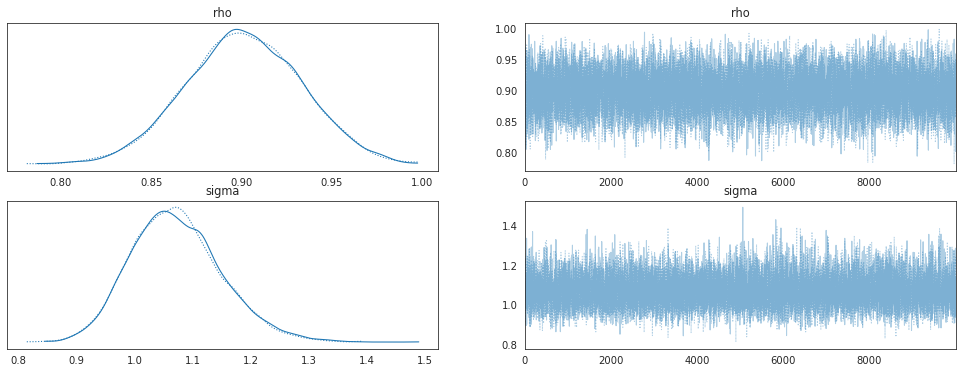

In [4]:
def draw_from_posterior(sample):
    """
    Draw a sample of size N from the posterior distribution.
    """

    AR1_model = pmc.Model()

    with AR1_model:
        
        # Start with priors
        rho = pmc.Uniform('rho',lower=-1.,upper=1.)  # Assume stable rho
        sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

        # Expected value of y at the next period (rho * y)
        yhat = rho * sample[:-1]

        # Likelihood of the actual realization.
        y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=sample[1:])

    with AR1_model:
        trace = pmc.sample(10000, tune=5000)

    # check condition
    with AR1_model:
        az.plot_trace(trace, figsize=(17, 6))
    
    rhos = trace.posterior.rho.values.flatten()
    sigmas = trace.posterior.sigma.values.flatten()

    post_sample = {
        'rho': rhos,
        'sigma': sigmas
    }
    
    return post_sample

post_samples = draw_from_posterior(initial_path)

The graphs on the left portray posterior marginal distributions.

## Calculating Sample Path Statistics

Our next step is to prepare Python code to compute our sample path statistics.

In [5]:
# define statistics
def next_recession(omega):
    n = omega.shape[0] - 3
    z = np.zeros(n, dtype=int)
    
    for i in range(n):
        z[i] = int(omega[i] <= omega[i+1] and omega[i+1] > omega[i+2] and omega[i+2] > omega[i+3])

    if np.any(z) == False:
        return 500
    else:
        return np.where(z==1)[0][0] + 1

def minimum_value(omega):
    return min(omega[:8])

def severe_recession(omega):
    z = np.diff(omega)
    n = z.shape[0]
    
    sr = (z < -.02).astype(int)
    indices = np.where(sr == 1)[0]

    if len(indices) == 0:
        return T1
    else:
        return indices[0] + 1

def next_turning_point(omega):
    """
    Suppose that omega is of length 6
    
        y_{t-2}, y_{t-1}, y_{t}, y_{t+1}, y_{t+2}, y_{t+3}
    
    that is sufficient for determining the value of P/N    
    """
    
    n = np.asarray(omega).shape[0] - 4
    T = np.zeros(n, dtype=int)
    
    for i in range(n):
        if ((omega[i] > omega[i+1]) and (omega[i+1] > omega[i+2]) and 
            (omega[i+2] < omega[i+3]) and (omega[i+3] < omega[i+4])):
            T[i] = 1
        elif ((omega[i] < omega[i+1]) and (omega[i+1] < omega[i+2]) and 
            (omega[i+2] > omega[i+3]) and (omega[i+3] > omega[i+4])):
            T[i] = -1
    
    up_turn = np.where(T == 1)[0][0] + 1 if (1 in T) == True else T1
    down_turn = np.where(T == -1)[0][0] + 1 if (-1 in T) == True else T1

    return up_turn, down_turn

## Original Wecker Method

Now we  apply Wecker's original  method by simulating future paths and compute predictive distributions, conditioning
on the true  parameters associated with the data-generating model.

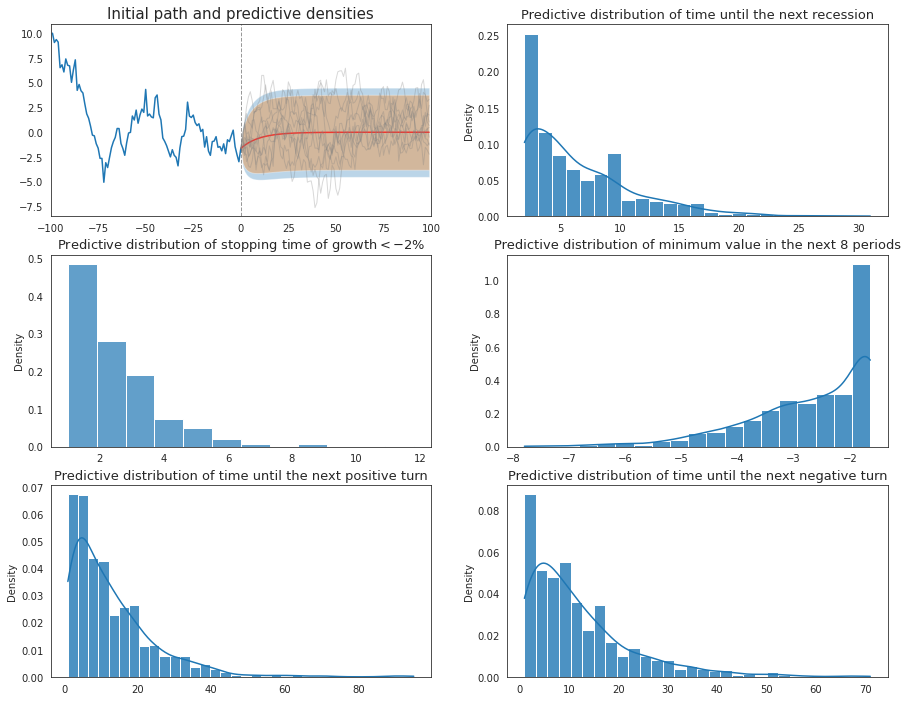

In [6]:
def plot_Wecker(initial_path, N, ax):
    """
    Plot the predictive distributions from "pure" Wecker's method.
    """
    # Store outcomes
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)
    
    # Compute .9 confidence interval]
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # Plot
    ax[0, 0].set_title("Initial path and predictive densities", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Plot 90% CI
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3)
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35)
    ax[0, 0].plot(np.arange(T1), center, color='red', alpha=.7)

    # Simulate future paths
    for n in range(N):
        sim_path = AR1_simulate(rho, sigma, initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n%(N/10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
            
    # Return next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.8, label='True parameters')
    ax[0, 1].set_title("Predictive distribution of time until the next recession", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=0.9, alpha=.7, label='True parameters')
    ax[1, 0].set_title(r"Predictive distribution of stopping time of growth$<-2\%$", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.8, label='True parameters')
    ax[1, 1].set_title("Predictive distribution of minimum value in the next 8 periods", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.8, label='True parameters')
    ax[2, 0].set_title("Predictive distribution of time until the next positive turn", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.8, label='True parameters')
    ax[2, 1].set_title("Predictive distribution of time until the next negative turn", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
plt.show()

## Extended Wecker Method

Now we apply we apply our  "extended" Wecker method based on  predictive densities of $y$ defined by
{eq}`ar1-tp-eq4` that acknowledge posterior uncertainty in the parameters $\rho, \sigma$.

To approximate  the intergration on the right side of {eq}`ar1-tp-eq4`, we  repeatedly draw parameters from the joint posterior distribution each time we simulate a sequence of future values from model {eq}`ar1-tp-eq1`.

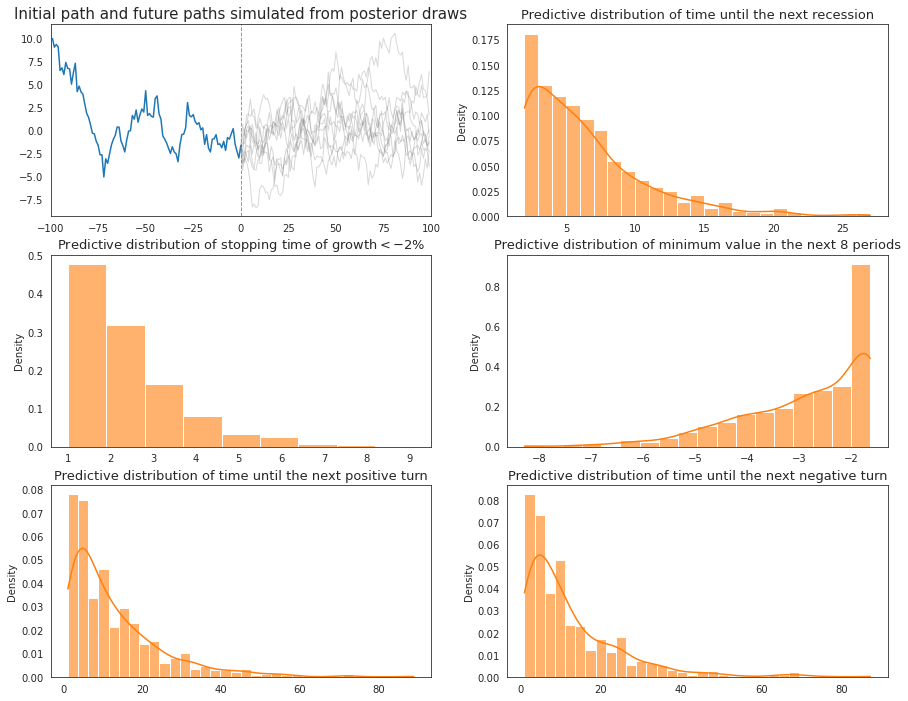

In [7]:
def plot_extended_Wecker(post_samples, initial_path, N, ax):
    """
    Plot the extended Wecker's predictive distribution
    """
    # Select a sample
    index = np.random.choice(np.arange(len(post_samples['rho'])), N + 1, replace=False)
    rho_sample = post_samples['rho'][index]
    sigma_sample = post_samples['sigma'][index]

    # Store outcomes
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)

    # Plot
    ax[0, 0].set_title("Initial path and future paths simulated from posterior draws", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Simulate future paths
    for n in range(N):
        sim_path = AR1_simulate(rho_sample[n], sigma_sample[n], initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n % (N / 10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
        
    # Return next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[0, 1].set_title("Predictive distribution of time until the next recession", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=.9, alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[1, 0].set_title(r"Predictive distribution of stopping time of growth$<-2\%$", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[1, 1].set_title("Predictive distribution of minimum value in the next 8 periods", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[2, 0].set_title("Predictive distribution of time until the next positive turn", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[2, 1].set_title("Predictive distribution of time until the next negative turn", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.show()

## Comparison

Finally, we plot both the original Wecker method and the extended method with parameter values drawn from the posterior together to compare the differences that emerge from pretending to know parameter values when they are actually uncertain.

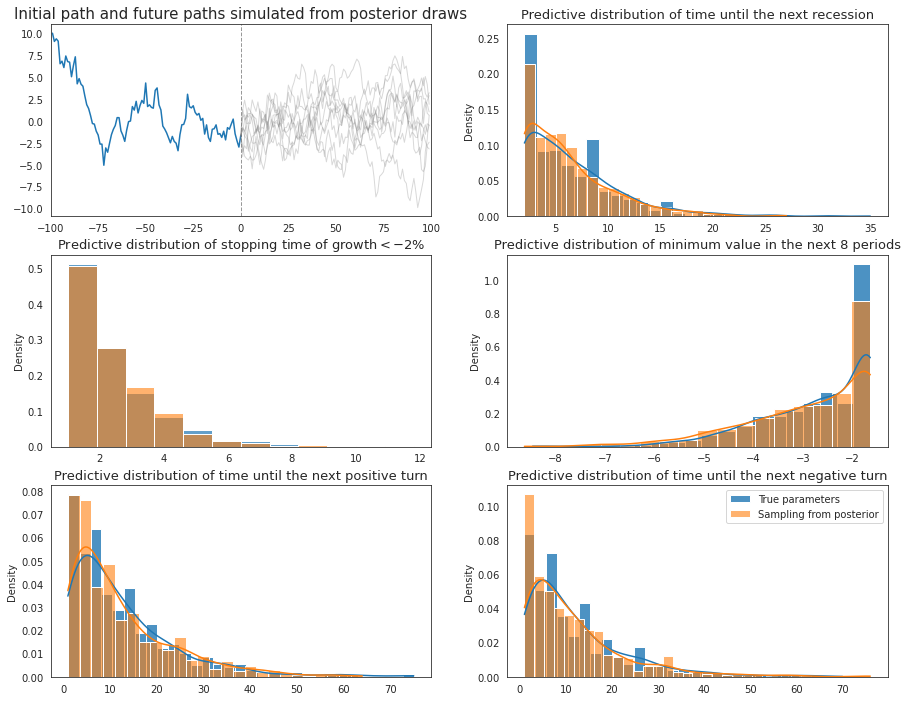

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
ax[0, 0].clear()
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.legend()
plt.show()